# Tarefa 02
Nesta tarefa vocês irão projetar duas arquiteturas de CNN utilizando os conceitos, camadas e técnicas vistas no curso. As redes serão treinadas no dataset CIFAR-10 e depois comparadas. As tarefas são:

**1) Definir as arquiteturas; ----> 0.3 pontos** 

- Quantas [camadas](https://keras.io/layers/core/) ela terá?
- Quais as operações utilizadas (convoluções, pooling, fully-connected)?
- Quais serão os parâmetros de cada camada (número e tamanho dos filtros convolucionais, stride, tamanho do pooling, funções de ativação)?
- Que tipo de [inicialização](https://keras.io/initializers/) de pesos você utilizará?
- Haverá dropout? Qual a taxa de dropout? 
- Haverá [regularização](https://keras.io/regularizers/)? Qual a taxa do regularizador?

**2) Definir como será o treino; ----> 0.25 pontos**
- Número de épocas e tamanho do batch (deixe igual p/ as duas redes);
- [Otimizador](https://keras.io/optimizers/);
- [Função de custo](https://keras.io/losses/);

**3) Classificar o conjunto de teste e comparar os resultados; ----> 0.25 pontos**
- Classificar imagens de teste;
- Comparar acurácias;
- Plotar loss pelo número de épocas no conjunto de treinamento e validação de cada rede. 
    
**4) Escrever um parágrafo com as suas conclusões; ----> 0.2 pontos**

-----

## CIFAR-10
Este conjunto de dados é composto de 60000 imagens coloridas de dimensões 32x32, divididas em 10 classes (com 6000 imagens por classe), sendo 50000 para treinamento e 10000 para teste. As classes do CIFAR-10 são **aviões, automóveis, pássaros, gatos, alces, cachorros, sapos, cavalos, navios, caminhões.**

O código abaixo carrega e transforma os dados de entrada para ficarem prontos para serem treinados/classificados pela sua rede. Os conjuntos de treino, validação e teste estão balanceados, portanto a acurácia já estará normalizada nos métodos do Keras.  

In [19]:
#Imports
import os
from numpy import *
from random import seed
seed(42)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,15) # Make the figures a bit bigger

from keras.datasets import cifar10
from keras.utils import np_utils
#from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit


#Load data
(trainVal_data, trainVal_label), (X_test, y_test) = cifar10.load_data()

# Caso alguem tenha problemas com o StratifiedShuffleSplit, tente descomentar essa versao
#Split trainVal data into train and val sets (already balanced)
# splitIdx = StratifiedShuffleSplit(trainVal_label, 1, test_size=10000, random_state=0)
# for train_index, val_index in splitIdx:
#     X_train, X_val = trainVal_data[train_index], trainVal_data[val_index]
#     y_train, y_val = trainVal_label[train_index], trainVal_label[val_index]
    

splitIdx = StratifiedShuffleSplit(1, test_size=10000, random_state=0)
for train_index, val_index in splitIdx.split(trainVal_data, trainVal_label):
    X_train, X_val = trainVal_data[train_index], trainVal_data[val_index]
    y_train, y_val = trainVal_label[train_index], trainVal_label[val_index]

    
#Transform data
X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
X_val = X_val.reshape(X_val.shape[0], 32, 32, 3)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_val /= 255
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Validation matrix shape", X_val.shape)
print("Testing matrix shape", X_test.shape)

Y_train = np_utils.to_categorical(y_train, 10)
Y_val = np_utils.to_categorical(y_val, 10)
Y_test = np_utils.to_categorical(y_test, 10)

Training matrix shape (40000, 32, 32, 3)
Validation matrix shape (10000, 32, 32, 3)
Testing matrix shape (10000, 32, 32, 3)


--------
--------
--------
**A tarefa de vocês começa aqui!!!**

# Definir as duas arquiteturas - [0.3 pontos]
***Não se esqueçam de***:
    - Importar as camadas utilizadas e o tipo do modelo (Sequential);
    - Passar o input_shape na primeira camada da rede;
    - Utilizar ativação `softmax` na última camada densa da rede;

In [21]:
#Imports
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import optimizers # other stuff needed ... 

import numpy as np
nb_classes=10
n_epochs=10
def reg_y(y):
    y_reg=[]
    for i in range(len(y)):
        y_reg.append(y[i][0])
    return y_reg
unique, counts = np.unique(y_train, return_counts=True)
print("Train ---> ", dict(zip(unique, counts)), "\n")

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', np.unique(reg_y(y_train)), reg_y(y_train))
train_class_weights = dict(enumerate(class_weights))

unique, counts = np.unique(y_test, return_counts=True)
test_sample_per_class = counts

Train --->  {0: 4000, 1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000, 6: 4000, 7: 4000, 8: 4000, 9: 4000} 



In [22]:
# define your model here
model = Sequential()

model.add(Conv2D(10, kernel_size=(5, 5),
activation='relu', #ReLU activation
input_shape=(32, 32, 3))) #no need to include the batch size

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(20, kernel_size=(5, 5),
activation='relu', #ReLU activation
input_shape=(14, 14, 3))) #no need to include the batch size

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(nb_classes, input_shape=(6000,), activation='softmax'))

modelOne=model

In [89]:
from keras import regularizers

# Define 2nd architecture
modelTwo = Sequential()

modelTwo.add(Conv2D(64, kernel_size=(7, 7), strides=(2,2), padding='valid', activation='relu', input_shape=(32, 32, 3)))

modelTwo.add(Conv2D(16, kernel_size=(5, 5)))

modelTwo.add(Conv2D(64, kernel_size=(3, 3)))
modelTwo.add(MaxPooling2D(pool_size=(1, 1)))

modelTwo.add(Dropout(0.25))

modelTwo.add(Conv2D(16, kernel_size=(1, 1)))
modelTwo.add(MaxPooling2D(pool_size=(1, 1)))
modelTwo.add(Dropout(0.25))

modelTwo.add(Conv2D(1000, kernel_size=(3, 3), strides=(2,2)))
modelTwo.add(MaxPooling2D(pool_size=(3, 3)))
modelTwo.add(Dropout(0.25))

modelTwo.add(Conv2D(1000, kernel_size=(1, 1)))

modelTwo.add(Flatten())

modelTwo.add(Dense(nb_classes, activation='softmax', 
                   kernel_regularizer=regularizers.l2(0.01),
                   activity_regularizer=regularizers.l1(0.01)))

# Treinamento - [0.25 pontos]
***Não se esqueçam de***:
    - Escolher otimizador e loss;
    - Compilar o modelo;
    - Definir número de épocas, tamanho do batch (utilizar o mesmo para ambas as redes);
    - Passar o conjunto de validação em `validation_data`;

In [14]:
#Compile first model
sgd = optimizers.SGD(lr=0.01) #lr = learning rate
modelOne.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
#Train first CNN
modelOne.fit(X_train, Y_train,
          batch_size=128, epochs=n_epochs, verbose=1,
          class_weight = train_class_weights, 
          validation_data=(X_val, Y_val))

Train on 40000 samples, validate on 10000 samples
Epoch 1/3
40000/40000 [==============================] - 37s 935us/step - loss: 1.8462 - acc: 0.3327 - val_loss: 1.7679 - val_acc: 0.3792
Epoch 2/3
19328/40000 [=============>................] - ETA: 20s - loss: 1.8096 - acc: 0.3457

KeyboardInterrupt: 

In [90]:
#Compile second model
modelTwo.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Train second CNN
historyTwo = modelTwo.fit(X_train, Y_train,
          batch_size=128, epochs=10, verbose=1,
          class_weight = train_class_weights, 
          validation_data=(X_val, Y_val))


Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 187s 5ms/step - loss: 3.2908 - acc: 0.2721 - val_loss: 3.0684 - val_acc: 0.3559
Epoch 2/10
40000/40000 [==============================] - 190s 5ms/step - loss: 2.9424 - acc: 0.3970 - val_loss: 2.8830 - val_acc: 0.4147
Epoch 3/10
40000/40000 [==============================] - 181s 5ms/step - loss: 2.8595 - acc: 0.4259 - val_loss: 2.8404 - val_acc: 0.4259
Epoch 4/10
40000/40000 [==============================] - 167s 4ms/step - loss: 2.7816 - acc: 0.4566 - val_loss: 2.7258 - val_acc: 0.4795
Epoch 5/10
40000/40000 [==============================] - 173s 4ms/step - loss: 2.7422 - acc: 0.4736 - val_loss: 2.6665 - val_acc: 0.5034
Epoch 6/10
40000/40000 [==============================] - 164s 4ms/step - loss: 2.6957 - acc: 0.4934 - val_loss: 2.6319 - val_acc: 0.5230
Epoch 7/10
40000/40000 [==============================] - 179s 4ms/step - loss: 2.6650 - acc: 0.5045 - val_loss: 2.6422 - 

# Resultados no conjunto de teste [0.25 pontos]
***Não se esqueçam de***:
    - Classificar as imagens do conjunto de teste utilizando cada rede;
    - Computar acurácia para cada rede;
    - Comparar ambas as acurácias;
    - Plotar loss pelo número de épocas no conjunto de treinamento e validação de cada rede. 

10000/10000 [==============================] - 6s 583us/step
Test loss: 1.6222729806900025
Test accuracy (NOT NORMALIZED): 0.532
{0: 0.0, 1: 0.062, 2: 0.0, 3: 0.899, 4: 0.032, 5: 0.0, 6: 0.001, 7: 0.0, 8: 0.001, 9: 0.004} 

Normalized Acc -->  0.09990000000000002


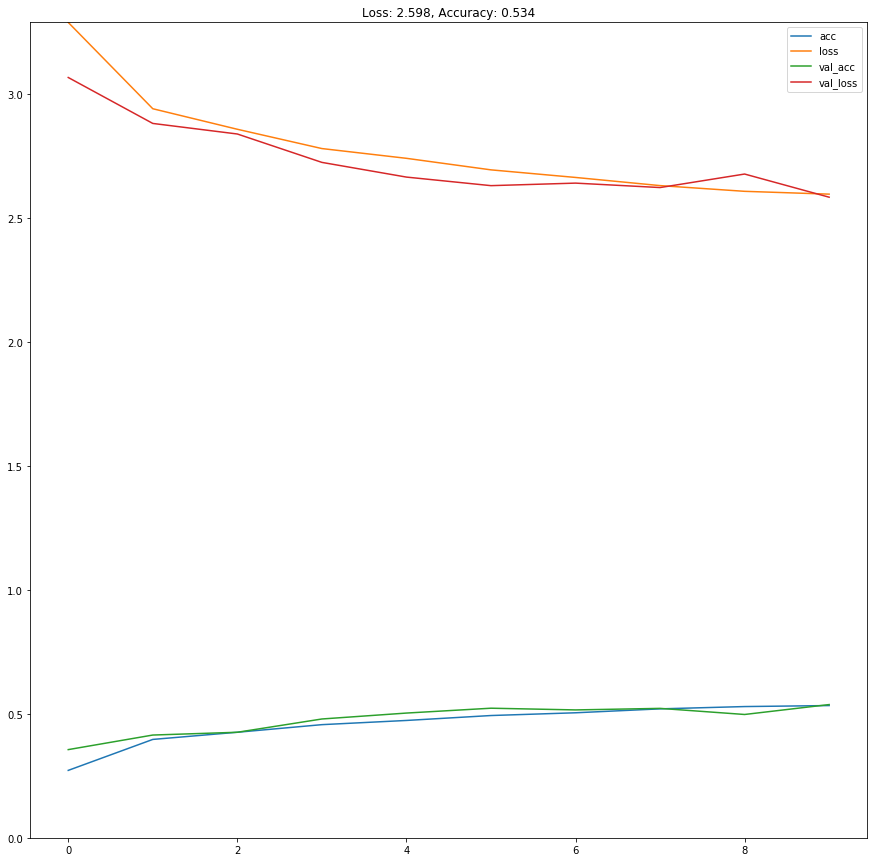

In [91]:
import pandas as pd

def av_model(model):
    # Classify test set
    score = model.evaluate(X_test, Y_test, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy (NOT NORMALIZED):', score[1])


    predicted_classes = modelOne.predict_classes(X_test)
    Y_test_classes = np.argmax(Y_test, axis=-1)

    accPerClass = []
    for classIdx in range(nb_classes):
        idx = (Y_test_classes == classIdx)

        correctPred = np.sum(predicted_classes[idx] == Y_test_classes[idx])
        accPerClass.append( correctPred / float(test_sample_per_class[classIdx]))

    print(dict(zip(range(19),accPerClass)), "\n")
    print("Normalized Acc --> ", np.mean(accPerClass))
    
def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['acc'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

plot_loss_accuracy(historyTwo)
av_model(modelTwo)

# Conclusões [0.2 pontos]
Escrevam um parágrafo com as conclusões que vocês tiraram na tarefa. Comentem as diferenças entre as duas arquiteturas e em seus treinamentos, apontando a motivação pelas decisões tomadas. Se o resultado ficou melhor/pior do que o que você esperava, o que você acha que pode ter acontecido?

In [10]:
# Write your paragraph here!